The magnetic variogram model is another way to represent spatial correlation in geostatistical modeling

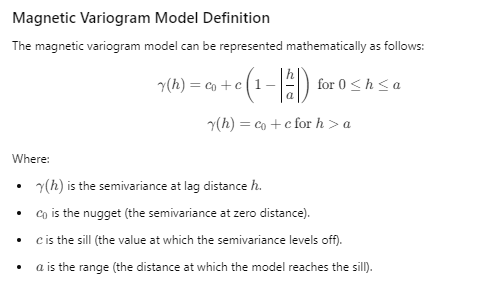

In [ ]:
pip install pykrige scikit-gstat numpy matplotlib


Length of empirical semivariances: 100
Length of lags: 100
Length of valid empirical semivariances: 100
Length of valid lags: 100


<ipython-input-28-6a6089990042>:46: RuntimeWarning: divide by zero encountered in divide
  return nugget + sill * (1 - np.exp(-h / range_))


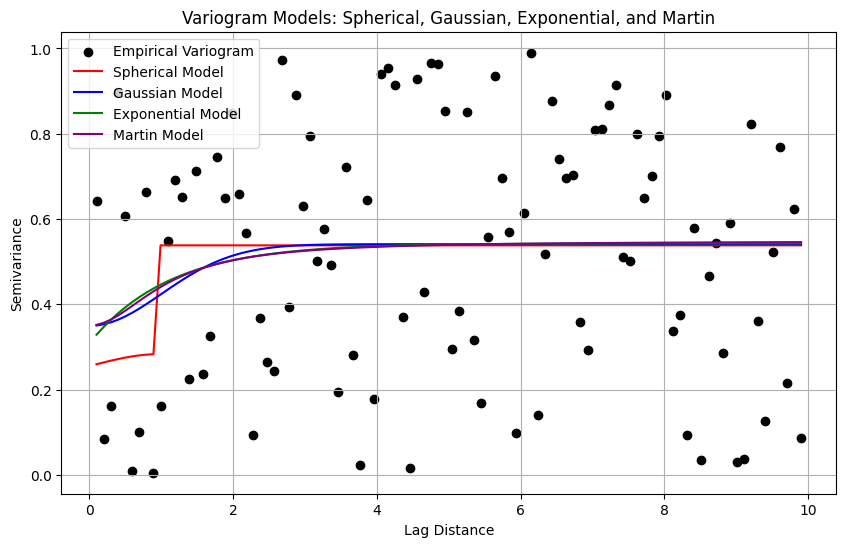

Spherical Model Parameters: [0.25514157 0.02800655 0.95765855], Success: True
Gaussian Model Parameters: [0.34941834 0.19163433 2.4649638 ], Success: True
Exponential Model Parameters: [0.30890085 0.23409377 1.12305557], Success: True
Martin Model Parameters: [0.35012289 0.19814095 1.08158247], Success: True


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from skgstat import Variogram
from scipy.optimize import minimize

# Generate synthetic data
np.random.seed(42)
n_points = 100
coords = np.random.rand(n_points, 2) * 100  # 2D spatial coordinates
z = np.random.rand(n_points)  # Random values for the variable

# Compute the empirical variogram
V = Variogram(coords, z, normalize=False, maxlag=10, n_lags=n_points) # make same as sample points

# Get empirical semivariances and corresponding lags
empirical_semivariances = V.values
lags = V.bins

# Print lengths for debugging
print(f"Length of empirical semivariances: {len(empirical_semivariances)}")
print(f"Length of lags: {len(lags)}")

# Check if lengths match
if len(empirical_semivariances) != len(lags):
    print("Mismatch between empirical semivariances and lags lengths.")
else:
    # Proceed with filtering and modeling if lengths match
    valid_indices = ~np.isnan(empirical_semivariances)
    empirical_semivariances_valid = empirical_semivariances[valid_indices]
    valid_lags = lags[valid_indices]

    # Check lengths after filtering
    print(f"Length of valid empirical semivariances: {len(empirical_semivariances_valid)}")
    print(f"Length of valid lags: {len(valid_lags)}")

    # Check if valid lengths match
    if len(empirical_semivariances_valid) == len(valid_lags):
        # Define variogram models
        def spherical_model(h, nugget, sill, range_):
            return nugget + sill * (1.5 * h / range_ - 0.5 * (h / range_)**3) * (h <= range_) + (nugget + sill) * (h > range_)

        def gaussian_model(h, nugget, sill, range_):
            return nugget + sill * (1 - np.exp(-3 * (h / range_)**2))

        def exponential_model(h, nugget, sill, range_):
            return nugget + sill * (1 - np.exp(-h / range_))

        def martin_model(h, nugget, sill, range_):
            return nugget + sill * (h**2 / (range_**2 + h**2))

        # Fit the variogram models
        def fit_model(model_func, valid_lags, empirical_semivariances):
            def loss(params):
                return np.sum((empirical_semivariances - model_func(valid_lags, *params))**2)

            initial_params = [0, 1, 1]  # [nugget, sill, range]
            result = minimize(loss, initial_params, bounds=[(0, None), (0, None), (0, None)])
            return result.x, result.success

        # Fit all models
        spherical_params, spherical_success = fit_model(spherical_model, valid_lags, empirical_semivariances_valid)
        gaussian_params, gaussian_success = fit_model(gaussian_model, valid_lags, empirical_semivariances_valid)
        exponential_params, exponential_success = fit_model(exponential_model, valid_lags, empirical_semivariances_valid)
        martin_params, martin_success = fit_model(martin_model, valid_lags, empirical_semivariances_valid)

        # Prepare for plotting fitted models
        fitted_spherical = spherical_model(valid_lags, *spherical_params)
        fitted_gaussian = gaussian_model(valid_lags, *gaussian_params)
        fitted_exponential = exponential_model(valid_lags, *exponential_params)
        fitted_martin = martin_model(valid_lags, *martin_params)

        # Plot the empirical variogram
        plt.figure(figsize=(10, 6))
        plt.scatter(valid_lags, empirical_semivariances_valid, label='Empirical Variogram', color='black', marker='o')

        # Plot the fitted models
        plt.plot(valid_lags, fitted_spherical, label='Spherical Model', color='red')
        plt.plot(valid_lags, fitted_gaussian, label='Gaussian Model', color='blue')
        plt.plot(valid_lags, fitted_exponential, label='Exponential Model', color='green')
        plt.plot(valid_lags, fitted_martin, label='Martin Model', color='purple')

        # Add legends and labels
        plt.legend()
        plt.title('Variogram Models: Spherical, Gaussian, Exponential, and Martin')
        plt.xlabel('Lag Distance')
        plt.ylabel('Semivariance')
        plt.grid()
        plt.show()

        # Print parameters for each model
        print(f"Spherical Model Parameters: {spherical_params}, Success: {spherical_success}")
        print(f"Gaussian Model Parameters: {gaussian_params}, Success: {gaussian_success}")
        print(f"Exponential Model Parameters: {exponential_params}, Success: {exponential_success}")
        print(f"Martin Model Parameters: {martin_params}, Success: {martin_success}")

    else:
        print("Valid empirical semivariances and lags do not match in length.")


Length of empirical semivariances: 100
Length of lags: 100
Length of valid empirical semivariances: 100
Length of valid lags: 100


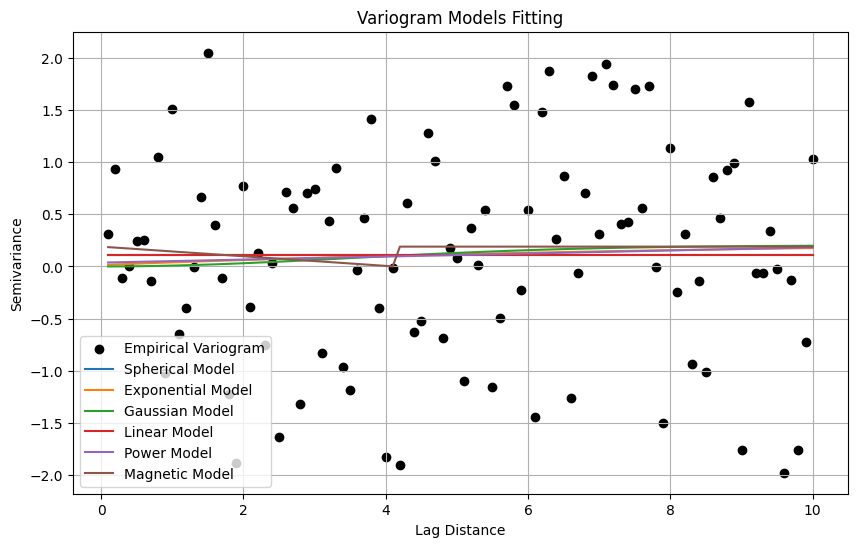

Spherical Model Parameters: Nugget (c0) = 0.0000, Sill (c) = 0.1102, Range (a) = 0.0346
Exponential Model Parameters: Nugget (c0) = 0.0136, Sill (c) = 0.2441, Range (a) = 9.1331
Gaussian Model Parameters: Nugget (c0) = 0.0000, Sill (c) = 0.2013, Range (a) = 4.9158
Linear Model Parameters: Nugget (c0) = 0.0822, Sill (c) = 0.3145, Range (a) = 0.0891
Power Model Parameters: Nugget (c0) = 0.0367, Sill (c) = 0.0144, Range (a) = 1.0062
Magnetic Model Parameters: Nugget (c0) = 0.0007, Sill (c) = 0.1893, Range (a) = 4.1000


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skgstat import Variogram
from scipy.optimize import curve_fit

# Generate example data: Coordinates (x, y) and some values (z)
np.random.seed(42)  # for reproducibility
n_points = 100
x = np.random.uniform(0, 10, n_points)
y = np.random.uniform(0, 10, n_points)
z = np.sin(x) + np.cos(y) + np.random.normal(0, 0.1, n_points)  # some random spatial pattern

# Combine the coordinates into a 2D array
coords = np.column_stack([x, y])

# Compute the empirical variogram
V = Variogram(coords, z, normalize=False, maxlag=10, n_lags=n_points)

# Get empirical semivariances and corresponding lags
empirical_semivariances = V.values
lags = V.bins

# Print lengths for debugging
print(f"Length of empirical semivariances: {len(empirical_semivariances)}")
print(f"Length of lags: {len(lags)}")

# Ensure that lags and empirical semivariances have the same size
if len(empirical_semivariances) != len(lags):
    print("Mismatch between empirical semivariances and lags lengths.")
else:
    # Check for NaN values and filter them
    valid_indices = ~np.isnan(empirical_semivariances)
    empirical_semivariances_valid = empirical_semivariances[valid_indices]
    valid_lags = lags[valid_indices]

    # Check lengths after filtering
    print(f"Length of valid empirical semivariances: {len(empirical_semivariances_valid)}")
    print(f"Length of valid lags: {len(valid_lags)}")

    # Define variogram models
    def spherical_model(h, c0, c, a):
        return np.where(h <= a, c0 + c * (1.5 * (h / a) - 0.5 * (h / a)**3), c0 + c)

    def exponential_model(h, c0, c, a):
        return c0 + c * (1 - np.exp(-h / a))

    def gaussian_model(h, c0, c, a):
        return c0 + c * (1 - np.exp(- (h**2) / (a**2)))

    def linear_model(h, c0, c, a):
        return np.where(h <= a, c0 + c * h, c0 + c * a)

    def power_model(h, c0, c, a):
        return c0 + c * (h**a)

    def magnetic_model(h, c0, c, a):
        return np.where(h <= a, c0 + c * (1 - (h / a)), c0 + c)

    # Fit each model to the empirical variogram
    models = {
        'Spherical': spherical_model,
        'Exponential': exponential_model,
        'Gaussian': gaussian_model,
        'Linear': linear_model,
        'Power': power_model,
        'Magnetic': magnetic_model,
    }

    params = {}

    # Fit models only if valid indices are available
    if len(empirical_semivariances_valid) > 0 and len(valid_lags) > 0:
        for model_name, model_func in models.items():
            # Fit the model
            p0 = [0, 1, 1]  # Initial guess for c0, c, a
            try:
                param, _ = curve_fit(model_func, valid_lags, empirical_semivariances_valid, p0=p0, bounds=(0, [1, 10, 10]))
                params[model_name] = param
            except RuntimeError:
                print(f"Failed to fit {model_name}")

        # Plot the empirical variogram and fitted models
        plt.figure(figsize=(10, 6))
        plt.scatter(valid_lags, empirical_semivariances_valid, label='Empirical Variogram', color='black')

        # Plot fitted models
        for model_name, param in params.items():
            fitted_variogram = models[model_name](valid_lags, *param)
            plt.plot(valid_lags, fitted_variogram, label=f'{model_name} Model')

        # Add legends and labels
        plt.legend()
        plt.title('Variogram Models Fitting')
        plt.xlabel('Lag Distance')
        plt.ylabel('Semivariance')
        plt.grid()
        plt.show()

        # Print fitted parameters for each model
        for model_name, param in params.items():
            print(f"{model_name} Model Parameters: Nugget (c0) = {param[0]:.4f}, Sill (c) = {param[1]:.4f}, Range (a) = {param[2]:.4f}")
    else:
        print("No valid data points to fit the models.")


Length of empirical semivariances: 100
Length of lags: 100
Length of valid empirical semivariances: 100
Length of valid lags: 100


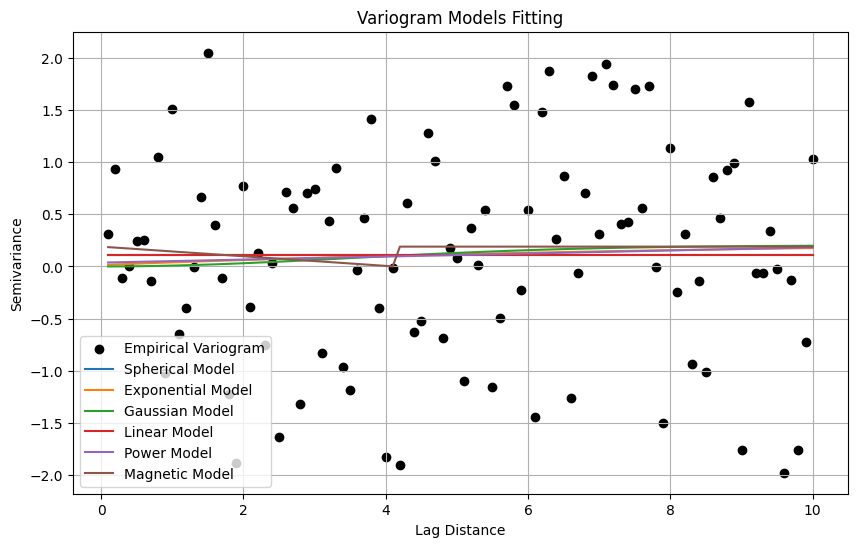

Spherical Model Parameters: Nugget (c0) = 0.0000, Sill (c) = 0.1102, Range (a) = 0.0346
Spherical AIC: 5.3370, BIC: 13.1525
Exponential Model Parameters: Nugget (c0) = 0.0136, Sill (c) = 0.2441, Range (a) = 9.1331
Exponential AIC: 5.1221, BIC: 12.9377
Gaussian Model Parameters: Nugget (c0) = 0.0000, Sill (c) = 0.2013, Range (a) = 4.9158
Gaussian AIC: 4.7411, BIC: 12.5566
Linear Model Parameters: Nugget (c0) = 0.0822, Sill (c) = 0.3145, Range (a) = 0.0891
Linear AIC: 5.3370, BIC: 13.1525
Power Model Parameters: Nugget (c0) = 0.0367, Sill (c) = 0.0144, Range (a) = 1.0062
Power AIC: 5.1581, BIC: 12.9736
Magnetic Model Parameters: Nugget (c0) = 0.0007, Sill (c) = 0.1893, Range (a) = 4.1000
Magnetic AIC: 4.1371, BIC: 11.9527
The best model based on AIC is: Magnetic
The best model based on BIC is: Magnetic


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from skgstat import Variogram
from scipy.optimize import curve_fit

# Generate example data: Coordinates (x, y) and some values (z)
np.random.seed(42)  # for reproducibility
n_points = 100
x = np.random.uniform(0, 10, n_points)
y = np.random.uniform(0, 10, n_points)
z = np.sin(x) + np.cos(y) + np.random.normal(0, 0.1, n_points)  # some random spatial pattern

# Combine the coordinates into a 2D array
coords = np.column_stack([x, y])

# Compute the empirical variogram
V = Variogram(coords, z, normalize=False, maxlag=10, n_lags=n_points)

# Get empirical semivariances and corresponding lags
empirical_semivariances = V.values
lags = V.bins

# Ensure lengths are printed for debugging
print(f"Length of empirical semivariances: {len(empirical_semivariances)}")
print(f"Length of lags: {len(lags)}")

# Check for NaN values and filter them
valid_indices = ~np.isnan(empirical_semivariances)
empirical_semivariances_valid = empirical_semivariances[valid_indices]
valid_lags = lags[valid_indices]

# Check lengths after filtering
print(f"Length of valid empirical semivariances: {len(empirical_semivariances_valid)}")
print(f"Length of valid lags: {len(valid_lags)}")

# Define variogram models
def spherical_model(h, c0, c, a):
    return np.where(h <= a, c0 + c * (1.5 * (h / a) - 0.5 * (h / a)**3), c0 + c)

def exponential_model(h, c0, c, a):
    return c0 + c * (1 - np.exp(-h / a))

def gaussian_model(h, c0, c, a):
    return c0 + c * (1 - np.exp(- (h**2) / (a**2)))

def linear_model(h, c0, c, a):
    return np.where(h <= a, c0 + c * h, c0 + c * a)

def power_model(h, c0, c, a):
    return c0 + c * (h**a)

def magnetic_model(h, c0, c, a):
    return np.where(h <= a, c0 + c * (1 - (h / a)), c0 + c)

# Fit each model to the empirical variogram
models = {
    'Spherical': spherical_model,
    'Exponential': exponential_model,
    'Gaussian': gaussian_model,
    'Linear': linear_model,
    'Power': power_model,
    'Magnetic': magnetic_model,
}

params = {}
aic_values = {}
bic_values = {}

# Fit models only if valid indices are available
if len(empirical_semivariances_valid) > 0 and len(valid_lags) > 0:
    for model_name, model_func in models.items():
        # Fit the model
        p0 = [0, 1, 1]  # Initial guess for c0, c, a
        try:
            param, _ = curve_fit(model_func, valid_lags, empirical_semivariances_valid, p0=p0, bounds=(0, [1, 10, 10]))
            params[model_name] = param

            # Calculate residuals and log-likelihood
            fitted_variogram = model_func(valid_lags, *param)
            residuals = empirical_semivariances_valid - fitted_variogram
            rss = np.sum(residuals**2)
            n = len(empirical_semivariances_valid)
            k = len(param)  # number of parameters

            # Calculate AIC and BIC
            aic = n * np.log(rss / n) + 2 * k
            bic = n * np.log(rss / n) + k * np.log(n)
            aic_values[model_name] = aic
            bic_values[model_name] = bic

        except RuntimeError:
            print(f"Failed to fit {model_name}")

    # Plot the empirical variogram and fitted models
    plt.figure(figsize=(10, 6))
    plt.scatter(valid_lags, empirical_semivariances_valid, label='Empirical Variogram', color='black')

    # Plot fitted models
    for model_name, param in params.items():
        fitted_variogram = models[model_name](valid_lags, *param)
        plt.plot(valid_lags, fitted_variogram, label=f'{model_name} Model')

    # Add legends and labels
    plt.legend()
    plt.title('Variogram Models Fitting')
    plt.xlabel('Lag Distance')
    plt.ylabel('Semivariance')
    plt.grid()
    plt.show()

    # Print fitted parameters for each model and AIC/BIC values
    for model_name, param in params.items():
        print(f"{model_name} Model Parameters: Nugget (c0) = {param[0]:.4f}, Sill (c) = {param[1]:.4f}, Range (a) = {param[2]:.4f}")
        print(f"{model_name} AIC: {aic_values[model_name]:.4f}, BIC: {bic_values[model_name]:.4f}")

    # Determine the best model based on AIC
    best_aic_model = min(aic_values, key=aic_values.get)
    print(f"The best model based on AIC is: {best_aic_model}")

    # Determine the best model based on BIC
    best_bic_model = min(bic_values, key=bic_values.get)
    print(f"The best model based on BIC is: {best_bic_model}")

else:
    print("No valid data points to fit the models.")
